# Practica 2

Autor: Lucas Gallego Bravo

NIA: 100429005

# Imports

Antes de comenzar a implementar el código de la práctica, debemos realizar los imports necesarios para el correcto funcionamiento de la misma.

In [ ]:
!pip3 install numpy
!pip3 install pandas

import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from numpy.random import seed
from tensorflow.keras.utils import set_random_seed
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix,mean_squared_error

#from tensorflow.keras import datasets, layers, models
#import matplotlib.pyplot as plt

# Preprocesamiento de los datos

Una vez realizados los imports necesarios, podemos empezar a realizar el preprocesamiento de los datos. Lo cual ayudara a nuestro PM en la clasificación.

In [ ]:
# Lo primero que debemos realizar es la apertura de nuestro dataset:
# El path y file_ se pueden cambiar para acomodarse al path y fichero necesarios
path= "/content/"
file_ = "dataset.csv"
dataset = pd.read_csv(path + file_, header='infer', delimiter=',')

# Mediante estos prints podemos comprobar la dimensionalidad de nuestros datos y target y asi comprobar que tienen las dimensiones correctas:
print('Dataset(data): ',dataset.shape)

Dataset(data):  (29151, 23)


## Elección de las variables

Primero se van a eliminar todas las columnas std_, ya que solo nos interesa la media de los datos dados. También se eliminaran las columnas 'track_id' y 'user_id' al considerarse que son datos irrelevantes para la clasificación.

In [ ]:
# Ahora debemos seleccionar que columnas consideramos relevantes en nuestro dataset, dicho esto, primero borramos las columnas std_:

dataFrame = dataset.drop(columns=["std_delta_times", "std_hours", "std_distances", "std_velocities", "std_accelerations","std_headings","std_heading_changes","std_heading_change_rates","std_stops","std_turnings"] )

#Una vez borrados los std_, vamos a borrar tambien la columna track_id, ya que al tener la columna user_id se cree que track_id es innecesaria:

dataFrame = dataFrame.drop(columns=["track_id","user_id"])

dataFrame

,mean_delta_times,mean_hours,mean_distances,mean_velocities,mean_accelerations,mean_headings,mean_heading_changes,mean_heading_change_rates,mean_stops,mean_turnings,label
0,4.954975,4.0,7.370991,1.475115,0.000224,141.946162,2.357923,0.297172,0.079146,0.304824,0
1,4.890226,4.0,4.358587,0.833067,0.004301,154.832162,5.153850,6.498869,0.444698,0.613568,0
2,2.000000,1.0,2.298434,1.149217,0.002897,90.287825,0.338599,0.169300,0.835000,0.355000,0
3,2.000000,1.0,2.135659,1.067830,0.010021,85.249516,1.585766,0.792883,0.850603,0.339296,0
4,2.000000,1.0,0.321824,0.160912,0.003865,91.970513,0.810080,0.405040,0.988367,0.494121,0
...,...,...,...,...,...,...,...,...,...,...,...
29146,5.616181,1.0,77.617958,12.020115,0.017929,190.504070,1.334386,0.308397,0.020101,0.055276,3
29147,4.625779,1.0,36.301740,6.751808,0.028833,161.341672,2.354026,-0.320778,0.275427,0.260126,3
29148,21.353794,12.0,53.414140,2.565517,0.006307,163.727055,1.158802,0.400712,0.000000,0.308442,1
29149,3.427136,12.0,7.600539,3.523266,0.048029,112.152390,6.595061,2.322378,0.456131,0.292538,4


## Normalización de los datos

Una vez tenemos los datos limpios, podemos normalizar los datos en el rango de valores [0,1], lo hacemos solo de las 10 primeras columnas ya que la última (target) no debe ser modificada.

In [ ]:
maximos_col = dataFrame.max()

minimos_col = dataFrame.min()

i=0
j=0

while j < 10:

  min_column = maximos_col[j]
  max_column = minimos_col[j]

  var1 = dataFrame.iloc[i,j] - min_column
  var2 = max_column - min_column

  norm_val = var1 / var2

  dataFrame.iloc[i,j] = norm_val

  i += 1

  if i == 29151 :

    i = 0
    j += 1

In [ ]:
dataFrame

,mean_delta_times,mean_hours,mean_distances,mean_velocities,mean_accelerations,mean_headings,mean_heading_changes,mean_heading_change_rates,mean_stops,mean_turnings,label
0,0.974355,0.826087,0.997343,0.967323,0.596435,0.604068,0.639166,0.566907,0.920457,0.681148,0
1,0.974775,0.826087,0.998429,0.981546,0.594602,0.568125,0.590496,0.481978,0.553067,0.358196,0
2,0.993516,0.956522,0.999171,0.974542,0.595233,0.748159,0.674318,0.568658,0.160804,0.628663,0
3,0.993516,0.956522,0.999230,0.976345,0.592029,0.762213,0.652608,0.560118,0.145123,0.645089,0
4,0.993516,0.956522,0.999884,0.996435,0.594798,0.743466,0.666110,0.565430,0.006666,0.483140,0
...,...,...,...,...,...,...,...,...,...,...,...
29146,0.970068,0.956522,0.972016,0.733728,0.588473,0.468625,0.656984,0.566753,0.979798,0.942180,3
29147,0.976490,0.956522,0.986912,0.850432,0.583569,0.549968,0.639234,0.575369,0.723189,0.727903,3
29148,0.868024,0.478261,0.980742,0.943168,0.593700,0.543314,0.660040,0.565489,1.000000,0.677363,1
29149,0.984262,0.478261,0.997260,0.921952,0.574936,0.687172,0.565408,0.539173,0.541577,0.694000,4


## División entre train y test:
Dividimos nuestros datos entre train (2/3) y test (1/3), además, los transformamos en unos .csv los cuales descargaremos para su uso mas adelante.

In [ ]:
train = dataFrame[0:19434]

test = dataFrame[19434:]

train.to_csv('train.csv',index=False)

test.to_csv('test.csv',index=False)

# PARTE 1

## Apertura de train.csv y test.csv:

In [ ]:
path= "/content/"
file_ = "train.csv"
entrenamiento = pd.read_csv(path + file_, header='infer', delimiter=',')

file_ = "test.csv"
test = pd.read_csv(path + file_, header='infer', delimiter=',')

X_train = entrenamiento.iloc[: , :-1]
y_train = entrenamiento.iloc[:,-1:]

X_test = test.iloc[: , :-1]
y_test = test.iloc[:,-1:]

print("Shape X_train: ", X_train.shape)
print("Shape y_train: ", y_train.shape)
print("Shape X_test: ", X_test.shape)
print("Shape y_test: ", y_test.shape)

Shape X_train:  (19434, 10)
Shape y_train:  (19434, 1)
Shape X_test:  (9717, 10)
Shape y_test:  (9717, 1)


## Selección de una semilla:

Para que todos los procesos sean replicables aun haciendo uso de variables aleatorias, definimos una semilla.

In [ ]:
semilla=72 # segun la semilla, el futuro aleatorio funcionara siempre igual
seed(semilla)
set_random_seed(semilla)

## One-Hot-Encoding:

Una vez tenemos la división y normalización de nuestros datos, deberemos realizar one-hot-encoding a nuestra salida (target).

In [ ]:
encoder = LabelBinarizer()

y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.fit_transform(y_test)

Una vez tenemos los datos de entrenamiento preparados, debemos utilizarlos para sacar el conjunto de validación, el cual corresponde al 20% de los datos de entrenamiento.

In [ ]:
#Extraer del conjunto de train el conjunto de validación
X_train2, X_Validation, y_train_encoded2, y_Validation = train_test_split(X_train, y_train_encoded, stratify=y_train_encoded, test_size=0.2)

## Criterio de Parada

In [ ]:
#OPCIÓN 1
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  # métrica para monitorear
                               patience=1,  # número de épocas sin mejora antes de detener el entrenamiento
                               restore_best_weights=True,  # restaurar los mejores pesos después de detener
                               verbose=1)
callbacks_list=[early_stopping]

In [ ]:
#OPCIÓN 2
path= "/content/"
checkpoint = ModelCheckpoint(
                            'pesos_1.h5',  # nombre del archivo para guardar los pesos
                             monitor='val_loss',  # métrica para monitorear (puede ser 'val_loss', 'val_accuracy', etc.)
                             save_best_only=True,  # guarda solo si la métrica mejora
                             mode='min',  # 'max' si quieres maximizar la métrica, 'min' si quieres minimizar
                             save_weights_only=True,  # guarda solo los pesos, no el modelo completo
                             verbose=1)
callbacks_list = [checkpoint]

## Asignación de pesos
Para esta parte, he decidido asignar los pesos de manera automática, aunque es posible asignarlos manualmente.

In [ ]:
# Convertir las etiquetas one-hot de nuevo a un formato de una sola columna
y_train_single_column = np.argmax(y_train_encoded2, axis=1)


# CALCULACIÓN DE PESOS DE CLASE AUTOMÁTICOS
pesos = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_single_column),
    y=y_train_single_column
)

print(pesos)

# CREACIÓN DEL DICCIONARIO DE PESOS DE CLASE
class_weights = {i: pesos[i] for i in range(len(pesos))}

print(class_weights)

[0.5265707  1.07442985 0.88385446 1.32880342 3.49370787]
{0: 0.5265707027942421, 1: 1.0744298548721494, 2: 0.8838544627629334, 3: 1.3288034188034188, 4: 3.493707865168539}


## Definir el modelo de red neuronal

In [ ]:
# Definir forma de la entrada de la red
input_shape=(X_train2.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla

# Definir la salida de la red, la ultima capa debera tener una neurona por cada clase
num_classes = y_train_encoded2.shape[1] # definimos el numero de clases que queremos que tenga la salida

#DEFINICIÓN DEL MODELO
model = Sequential()

# Capa de entrada del modelo
model.add(Dense(50, input_shape=input_shape, activation='sigmoid'))

#Capas ocultas:
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(50, activation='sigmoid'))

# Capa de salida del modelo
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 50)                550       
                                                                 
 dense_73 (Dense)            (None, 50)                2550      
                                                                 
 dense_74 (Dense)            (None, 50)                2550      
                                                                 
 dense_75 (Dense)            (None, 5)                 255       
                                                                 
Total params: 5905 (23.07 KB)
Trainable params: 5905 (23.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Hiperparámetros

In [ ]:
# Hiperparametros
lr = 0.00003 # razon de aprendizaje
momento=0
epochs_H = 200 # numero de ciclos que se quiere realizar en el entrenamiento
batch_size_H = 32
optimizador=tf.keras.optimizers.SGD(learning_rate=lr, momentum=momento)
#lr=1e-3
#optimizador=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
#rho=0.9
#lr=0.001
#optimizador=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),

## Compilación del modelo

In [ ]:
#COMPILACIÓN DEL MODELO

model.compile(
    optimizer = optimizador,
    #optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
    #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    loss='mean_squared_error',
    #loss='binary_crossentropy',
    metrics=['accuracy','mse']
)

## Entrenamiento del modelo

In [ ]:
#ENTRENAMIENTO DEL MODELO
opcion=2
if opcion==1:
  callbacks_list=[early_stopping]

historico = model.fit(X_train2, y_train_encoded2,
                      epochs = epochs_H, batch_size = batch_size_H, verbose=1, validation_data=(X_Validation,y_Validation), shuffle=False,
                      callbacks=callbacks_list,
                      class_weight=class_weights)

Epoch 1/200
479/486 [============================>.] - ETA: 0s - loss: 0.1911 - accuracy: 0.1504 - mse: 0.1981
Epoch 1: val_loss improved from inf to 0.19795, saving model to pesos_1.h5
486/486 [==============================] - 5s 8ms/step - loss: 0.1911 - accuracy: 0.1505 - mse: 0.1981 - val_loss: 0.1979 - val_accuracy: 0.1505 - val_mse: 0.1979
Epoch 2/200
482/486 [============================>.] - ETA: 0s - loss: 0.1907 - accuracy: 0.1503 - mse: 0.1978
Epoch 2: val_loss improved from 0.19795 to 0.19759, saving model to pesos_1.h5
486/486 [==============================] - 6s 12ms/step - loss: 0.1908 - accuracy: 0.1505 - mse: 0.1978 - val_loss: 0.1976 - val_accuracy: 0.1505 - val_mse: 0.1976
Epoch 3/200
482/486 [============================>.] - ETA: 0s - loss: 0.1904 - accuracy: 0.1503 - mse: 0.1974
Epoch 3: val_loss improved from 0.19759 to 0.19723, saving model to pesos_1.h5
486/486 [==============================] - 4s 7ms/step - loss: 0.1905 - accuracy: 0.1505 - mse: 0.1974 - va

## Análisis de los resultados

In [ ]:
#GUARDAR RESULTADOS Y MODELOS EN FICHEROS
#CUANDO SE UTILIZA CHECKPOINT, YA ESTÁ GUARDADO EL MODELO
#CUANDO SE UTILIZA EARLY_STOPING, REALEMNTE EL MODELO YA ESTÁ EN "MODEL", PERO SI SE QUIERE GUARDAR EN FICHERO SE DEBE UTILIZAR MODEL.SAVE

np.savetxt(path+'historicoTrainLoss.txt',historico.history['loss'])
np.savetxt(path+'historicoValLoss.txt',historico.history['val_loss'])
np.savetxt(path+'historicoTrainAcc.txt',historico.history['accuracy'])
np.savetxt(path+'historicoValAcc.txt',historico.history['val_accuracy'])

if opcion==1:
    model.save(path+'model_early_stoping')

In [ ]:
#LOSS y ACCURACY DE TRAIN Y VALIDACIÓN CUANDO SE UTILIZA EARLY_STOPPING
final_epoch = len(historico.history['loss'])
print(historico.history['loss'][final_epoch-1])
print(historico.history['val_loss'][final_epoch-1])
print(historico.history['accuracy'][final_epoch-1])
print(historico.history['val_accuracy'][final_epoch-1])

0.16031897068023682
0.16101780533790588
0.24454878270626068
0.2508361339569092


In [ ]:
#MEJOR ÉPOCA, LOSS , ACCURACY Y MSE DE TRAIN Y VALIDACIÓN CUANDO SE UTILIZA CHECKPOINT
epochs_stop = np.where(historico.history['val_loss'] == np.min(historico.history['val_loss']))
final_epoch = epochs_stop[0][0]
print(final_epoch)
print(historico.history['loss'][final_epoch-1])
print(historico.history['val_loss'][final_epoch-1])
print(historico.history['accuracy'][final_epoch-1])
print(historico.history['val_accuracy'][final_epoch-1])
print(historico.history['mse'][final_epoch-1])
print(historico.history['val_mse'][final_epoch-1])

199
0.16888286173343658
0.1678536981344223
0.15051135420799255
0.15050166845321655
0.16790823638439178
0.1678536981344223


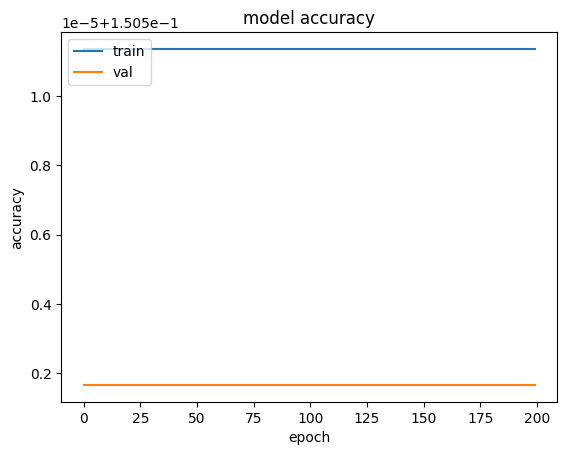

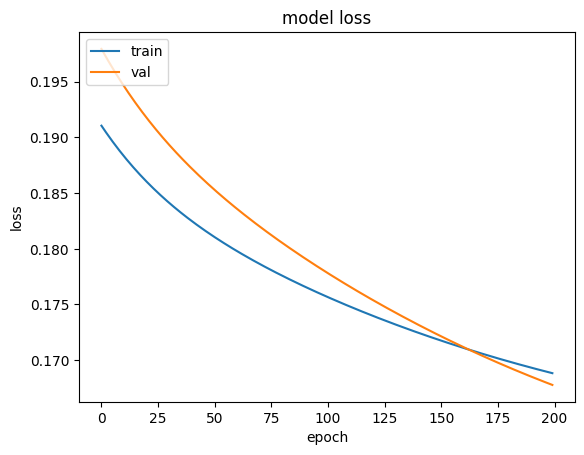

In [ ]:
## plots de evolución de loss y accuracy
from matplotlib import pyplot as plt
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Mejor modelo

Uso de checkpoint para obtener los mejores pesos posteriormente

In [ ]:
path= "/content/"
checkpoint = ModelCheckpoint(
                            'pesos.h5',  # nombre del archivo para guardar los pesos
                             monitor='loss',  # métrica para monitorear (puede ser 'val_loss', 'val_accuracy', etc.)
                             save_best_only=True,  # guarda solo si la métrica mejora
                             mode='min',  # 'max' si quieres maximizar la métrica, 'min' si quieres minimizar
                             save_weights_only=True,  # guarda solo los pesos, no el modelo completo
                             verbose=1)
callbacks_list = [checkpoint]

Pesos balanceados

In [ ]:
# Pesos originales :  [0.5265707  1.07442985 0.88385446 1.32880342 3.49370787]

# Encuentra el peso mínimo
min_weight = min(class_weights.values())

# Normaliza los pesos dividiendo por el peso mínimo
balanced_weights = {k: v / min_weight for k, v in class_weights.items()}

# Muestra los pesos equilibrados
print(balanced_weights)

{0: 1.0, 1: 2.0404284727021427, 2: 1.6785105173393975, 3: 2.523504273504274, 4: 6.634831460674158}


Definicion del modelo

In [ ]:
# Definir forma de la entrada de la red
input_shape=(X_train2.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla

# Definir la salida de la red, la ultima capa debera tener una neurona por cada clase
num_classes = y_train_encoded2.shape[1] # definimos el numero de clases que queremos que tenga la salida

#DEFINICIÓN DEL MODELO
model = Sequential()

# Capa de entrada del modelo
model.add(Dense(50, input_shape=input_shape, activation='sigmoid'))

#Capas ocultas:
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(50, activation='sigmoid'))

# Capa de salida del modelo
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 50)                550       
                                                                 
 dense_69 (Dense)            (None, 50)                2550      
                                                                 
 dense_70 (Dense)            (None, 50)                2550      
                                                                 
 dense_71 (Dense)            (None, 5)                 255       
                                                                 
Total params: 5905 (23.07 KB)
Trainable params: 5905 (23.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Hiperparametros

In [ ]:
# Hiperparametros
lr = 0.00003 # razon de aprendizaje
momento=0
epochs_H = 200 # numero de ciclos que se quiere realizar en el entrenamiento
batch_size_H = 32
optimizador=tf.keras.optimizers.SGD(learning_rate=lr, momentum=momento)
#lr=1e-3
#optimizador=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
#rho=0.9
#lr=0.001
#optimizador=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),

Compilación del modelo

In [ ]:
model.compile(
    optimizer = optimizador,
    #optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
    #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    loss='mean_squared_error',
    #loss='binary_crossentropy',
    metrics=['accuracy','mse']
)

Entrenamiento del modelo

In [ ]:
#ENTRENAMIENTO DEL MODELO SIN VALIDACION
opcion=2
if opcion==1:
  callbacks_list=[early_stopping]

historico = model.fit(X_train, y_train_encoded,
                      epochs = epochs_H, batch_size = batch_size_H, verbose=1, shuffle=False,
                      callbacks=callbacks_list,
                      class_weight=class_weights)

Epoch 1/200
593/608 [============================>.] - ETA: 0s - loss: 0.1897 - accuracy: 0.2270 - mse: 0.1779
Epoch 1: loss improved from inf to 0.18937, saving model to pesos.h5
608/608 [==============================] - 2s 2ms/step - loss: 0.1894 - accuracy: 0.2263 - mse: 0.1780
Epoch 2/200
602/608 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.2264 - mse: 0.1775
Epoch 2: loss improved from 0.18937 to 0.18882, saving model to pesos.h5
608/608 [==============================] - 2s 3ms/step - loss: 0.1888 - accuracy: 0.2263 - mse: 0.1775
Epoch 3/200
583/608 [===========================>..] - ETA: 0s - loss: 0.1876 - accuracy: 0.2291 - mse: 0.1765
Epoch 3: loss improved from 0.18882 to 0.18829, saving model to pesos.h5
608/608 [==============================] - 2s 3ms/step - loss: 0.1883 - accuracy: 0.2263 - mse: 0.1769
Epoch 4/200
593/608 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.2270 - mse: 0.1763
Epoch 4: loss improved from 0.18

## Predicción sobre test

In [ ]:
# Carga los mejores pesos
model.load_weights('pesos.h5')

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)

# Convertir las etiquetas reales a clases (índice de la clase con valor 1 en la codificación one-hot)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Evaluamos el modelo para sacar el MSE y accuracy
evaluate =  model.evaluate(X_test, y_test_encoded)

# Calcular y mostrar las métricas de evaluación
accuracy = evaluate[1]
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)
mse_test = evaluate[2]  # El índice 2 corresponde a la métrica 'mse' en la lista de métricas

print(f"Recall: {recall:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Matriz de Confusión: \n")
print(confusion_mat)

304/304 [==============================] - 1s 2ms/step - loss: 0.1550 - accuracy: 0.2224 - mse: 0.1550
Recall: 0.2224
Precisión: 0.0495
F1-Score: 0.0809
Matriz de Confusión: 

[[   0    0 3517    0    0]
 [   0    0 1925    0    0]
 [   0    0 2161    0    0]
 [   0    0 1478    0    0]
 [   0    0  636    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Guardar la predicción

In [ ]:
resultados_test = pd.DataFrame(columns=["Target","Predicciones","Clase predicha"])

i = 0
while i < 9717:
  var1 = y_pred[i]
  var2 = y_test.loc[i,"label"] #solo queremos la clase
  clase_predicha = np.argmax(var1)
  resultados_test.loc[i] = [var2,var1,clase_predicha]
  i = i + 1

# Una vez se tiene esto hecho, se puede guardar como un fichero:
resultados_test.to_csv('resultados_test.csv', index=False)
archivo_txt = 'resultados_test.txt'

# Escribe los datos en el archivo de texto
resultados_test.to_csv(archivo_txt, index=False, sep='\t')  # 'sep' es el delimitador, aquí se usa tabulación